# Single Scenario FaIR Model (removing pandas)

### Below is E's code adapting N's to a single scenario run, and only using numpy calculations

In [74]:
## import required dependencies ##

import numpy as np
import numexpr as ne
import scipy as sp
import os
import csv
from tqdm import tqdm

## extra  libraries for graphing ##

import sys
import matplotlib.pyplot as plt
import seaborn as sn

In [75]:
##define the functions for using in running FaIR ##

def return_gas_namelist_e():
    
    gas_namelist = ['bc',
                    'bc|aci',
                    'bc|bc_on_snow',
                    'c2f6',
                    'c3f8',
                    'c4f10',
                    'c5f12',
                    'c6f14',
                    'c7f16',
                    'c8f18',
                    'c_c4f8',
                    'carbon_dioxide',
                    'carbon_tetrachloride',
                    'carbon_tetrachloride|o3',
                    'cf4',
                    'cfc11',
                    'cfc113',
                    'cfc113|o3',
                    'cfc114',
                    'cfc114|o3',
                    'cfc115',
                    'cfc115|o3',
                    'cfc11|o3',
                    'cfc12',
                    'cfc12|o3',
                    'ch2cl2',
                    'ch2cl2|o3',
                    'ch3ccl3',
                    'ch3ccl3|o3',
                    'chcl3',
                    'chcl3|o3',
                    'co',
                    'co|o3',
                    'halon1202',
                    'halon1202|o3',
                    'halon1211',
                    'halon1211|o3',
                    'halon1301',
                    'halon1301|o3',
                    'halon2402',
                    'halon2402|o3',
                    'hcfc141b',
                    'hcfc141b|o3',
                    'hcfc142b',
                    'hcfc142b|o3',
                    'hcfc22',
                    'hcfc22|o3',
                    'hfc125',
                    'hfc134a',
                    'hfc143a',
                    'hfc152a',
                    'hfc227ea',
                    'hfc23',
                    'hfc236fa',
                    'hfc245fa',
                    'hfc32',
                    'hfc365mfc',
                    'hfc4310mee',
                    'methane',
                    'methane|strat_h2o',
                    'methane|o3',
                    'methyl_bromide',
                    'methyl_bromide|o3',
                    'methyl_chloride',
                    'methyl_chloride|o3',
                    'nf3',
                    'nh3',
                    'nitrous_oxide',
                    'nitrous_oxide|o3',
                    'nmvoc',
                    'nmvoc|o3',
                    'nox',
                    'nox_avi',
                    'nox_avi|contrails',
                    'nox|o3',
                    'oc',
                    'oc|aci',
                    'sf6',
                    'so2',
                    'so2f2',
                    'so2|aci'
                   ]
    
    return gas_namelist

def get_gas_parameter_defaults_e(choose_gases=return_gas_namelist_e()):

# this is the file that contains all the default parameters for running FaIR #
    
    CHOOSE_params = pd.read_csv(("Complete_gas_cycle_params.csv"),header=[0,1],index_col=0).reindex(choose_gases,axis=1,level=1)
    
    return CHOOSE_params

def get_thermal_parameter_defaults_e(TCR=1.79,RWF=0.552,F_2x=3.759):

# these parameters are taken from the 2021 paper Leach et al: https://gmd.copernicus.org/articles/14/3007/2021/gmd-14-3007-2021.pdf #

    d1 = 0.903
    d2 = 7.92
    d3 = 355
    q1 = 0.180
    ECS = TCR/RWF

    v1 = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )
    v2 = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )
    v3 = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )

    q3 = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))
    q2 = (ECS/F_2x - q1 -  q3)

    df = pd.DataFrame([[d1,d2,d3],[q1,q2,q3]],
                      index=['d','q'],
                      columns=pd.MultiIndex.from_product([['default parameters'],[1,2,3]])
                     )

    return df.apply(pd.to_numeric)

def calculate_alpha_e(G,G_A,T,r,g0,g1,iirf100_max = False):

# iirf100 is the average airborne fraction of the gases considered over a period of 100 years #
    
    iirf100_val = r[...,0] + r[...,1] * (G-G_A) + r[...,2] * T + r[...,3] * G_A
    
    if iirf100_max:
        
        if iirf100_val>iirf100_max:
            
            iirf100_val=iirf100_max

# alpha is the statedependent timescale adjustment factor; it scales the decay timescales of the gases considered, allowing for the effective sink from the atmosphere to change in strength over time #
    
    alpha_val = g0 * np.exp(iirf100_val / g1)

    return alpha_val

def step_forcing_e(C,PI_conc,f):

    RF=np.zeros_like(C)

    for i in range(len(C)):

# the logarithmic, linear, and square root forcing components are calculated and then summed to find the total realtive forcing for each gas [i] #
        
        if (C[i]/PI_conc[i]) <= 0:
            
            logforc=0
        else:
            
            logforc=f[i,0]*np.log(C[i]/PI_conc[i])

        linforc = f[i,1] * (C[i] - PI_conc[i])
    
        if C[i]<0:
            
           sqrtforc = f[i,2] * (np.sqrt(0) - np.sqrt(PI_conc[i]))
        else:
            
           sqrtforc = f[i,2] * (np.sqrt(C[i]) - np.sqrt(PI_conc[i]))
            
        RF[i] = logforc + linforc + sqrtforc
        
    return RF

def unstep_concentration_e(R_old,G_A,alpha,a,tau,dt=1):

# the unstep is for running FaIR backwards #
    
    decay_rate = dt/(alpha*tau)
    decay_factor = np.exp( -decay_rate )
    E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
    R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor

    return E,R_new


def step_temperature_e(S_old,F,q,d,dt=1):

    decay_factor = np.exp(-dt/d)
    S_new = q * F[0,...] * (1 - decay_factor) + S_old * decay_factor 
    T = np.sum((S_old + S_new)/2)

    return S_new,T

def step_concentration_e(R_old,G_A_old,E,alpha,a,tau,PI_conc,emis2conc,dt=1):

    R_new=np.zeros_like(a)
    
    for x in range(len(a[0])): # length of a[0] is the number of boxes, 4 at the moment, but this needs to be the same as tau
        
        for i in range(len(E)):

# there is something wrong in here with the calculations when not using pandas
            
            decay_rate = dt/(alpha[i]*tau[i,x])
            decay_factor = np.exp(-decay_rate)
            R_new[i,x] = E[i] * a[i,x] / decay_rate * ( 1. - decay_factor ) + R_old[i,x] * decay_factor # there shouldn't be a dt in the first decay rate
    G_A = np.sum(R_new, axis=1)
    C = PI_conc + emis2conc * (G_A + G_A_old) / 2

    return C,R_new,G_A

def return_empty_emissions_e(df_to_copy=False, start_year=1765, end_year=2500, timestep=1, gases_in = return_gas_namelist_e()):

# formatting a pandas dataframe that is empty, ready to be filled with emissions #

    df=np.zeros((end_year-start_year,len(gases_in)))

    return df

def return_empty_forcing_e(df_to_copy=False, start_year=1765, end_year=2500, timestep=1):

# formatting a pandas dataframe that is empty, ready to be filled with forcing #

    df=np.zeros_like(df_to_copy)
    
    return df

In [76]:
def run_FaIR_e (emissions_in=False,
             ext_forcing=False,
             concentrations_in=False, 
             gas_parameters=get_gas_parameter_defaults_e(),
             thermal_parameters=get_thermal_parameter_defaults_e(),
             iirf100_max=False, timestep=1):

    if emissions_in is False: 
        concentration_driven = True
        n_year = len(concentrations_in)
    else: 
        concentration_driven=False
        n_year = len(emissions_in)

    # for emissions driven it will work...
    if ext_forcing is False: 
        ext_forcing = return_empty_forcing_e(df_to_copy=emissions_in)
    
    #[(gas_set_names),(thermal_set_names)]=[(list(x)) for x in [gas_parameters,thermal_parameters]]

    gas_names = [x for x in gas_parameters if '|' not in x]
    n_gas = len(gas_names)
    n_forc = len(gas_parameters)
    #gas_forc_map = [gas_names.index(forc_names[x].split('|')[0]) for x in np.arange(len(forc_names))]

    timestep = np.ones(n_year)

    a,tau,r,PI_conc,emis2conc=[gas_parameters.loc[x].values.T for x in [['a1','a2','a3','a4'],['tau1','tau2','tau3','tau4'],['r0','rC','rT','rA'],'PI_conc','emis2conc']]
    d,q = [thermal_parameters.loc[x].values.T for x in ['d','q']]
    f = gas_parameters.loc['f1':'f3'].values.T

    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    g0 = np.exp( -1 * np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) 

    C = np.empty((n_gas,n_year))
    RF = np.empty((n_forc,n_year))
    T = np.empty((n_year))
    alpha = np.empty((n_gas,n_year))
    alpha[...,0] = calculate_alpha_e(G=0,G_A=0,T=0,r=r,g0=g0,g1=g1)

    
    names_list = ['gas_set_names','thermal_set_names',gas_names]
    names_titles = ['Gas cycle set','Thermal set','Gas name']
    forc_names_list = ['gas_set_names','thermal_set_names','forc_names']
    forc_names_titles = ['Gas cycle set','Thermal set','Forcing component']

    if concentration_driven:

        diagnosed_emissions = np.zeros((n_gas,n_year))
        C[:] = concentrations_in.values.T.reshape(n_gas,n_year)
        G_A = np.zeros_like(C)
        G_A[...,:-1] = concentrations_in.rolling(2).mean().dropna().values.T.reshape(n_gas,n_year-1)
        G_A[...,-1] = G_A[...,-2] + (C[...,-1]-C[...,-2]) #is it right to use -ve here??
        G_A = (G_A-PI_conc)/emis2conc
        RF[:] = step_forcing_e(C[...,:],PI_conc[...,:],f[...,np.newaxis,:])
        diagnosed_emissions[...,0],R = unstep_concentration_e(R_old=R_old,G_A=G_A[...,0],alpha=alpha[...,0,np.newaxis],a=a,tau=tau,dt=timestep[0])
        S,T[...,0] = step_temperature_e(S_old=0,F=np.sum(RF[...,0],axis=-1)[...,np.newaxis]+ext_forcing[0,:],q=q,d=d,dt=timestep[0])
        for t in tqdm(np.arange(n_year),unit=' timestep'):
            G = np.sum(diagnosed_emissions,axis=-1)
            alpha[...,t] = calculate_alpha_e(G=G,G_A=G_A[...,t-1],T=np.sum(S,axis=-1)[...,np.newaxis],r=r,g0=g0,g1=g1)
            diagnosed_emissions[...,t],R = unstep_concentration_e(R_old=R,G_A=G_A[...,t],alpha=alpha[...,t,np.newaxis],a=a,tau=tau,dt=timestep[t])
            S,T[...,t] = step_temperature_e(S_old=S,F=np.sum(RF[...,t],axis=-1)[...,np.newaxis]+ext_forcing[t,:],q=q,d=d,dt=timestep[t])

        C_out = concentrations_in.copy()
        E_out = np.moveaxis(diagnosed_emissions,-1,0).reshape(diagnosed_emissions.shape[-1],-1)

    if not concentration_driven:
        
        G = np.cumsum(emissions_in)

        R_old = np.zeros((emissions_in[0].size,4))
    
        C[...,0],R,G_A = step_concentration_e(R_old = R_old,G_A_old = 0,alpha=alpha[...,0,np.newaxis],E=emissions_in[0,:],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc[...,0],dt=timestep[0])
                
        RF[...,0] = step_forcing_e(C=C[...,0],PI_conc=PI_conc,f=f)
        
        S,T[...,0] = step_temperature_e(S_old=0,F=np.sum(RF[...,0],axis=-1)[...,np.newaxis]+ext_forcing[0,:],q=q,d=d,dt=timestep[0])

        for t in tqdm(np.arange(1,n_year),unit=' timestep'):
            
            alpha[...,t] = calculate_alpha_e(G=G[t-1],G_A=G_A,T=np.sum(S,axis=-1)[...,np.newaxis],r=r,g0=g0,g1=g1)
            
            C[...,t],R,G_A = step_concentration_e(R_old = R,G_A_old=G_A,alpha=alpha[...,t,np.newaxis],E=emissions_in[t,:],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc[...,0],dt=timestep[t])
            
            RF[...,t] = step_forcing_e(C=C[...,t],PI_conc=PI_conc,f=f)
            
            S,T[...,t] = step_temperature_e(S_old=S,F=np.sum(RF[...,t],axis=-1)[...,np.newaxis]+ext_forcing[t,:],q=q,d=d,dt=timestep[t])

        C_out = np.moveaxis(C,-1,0).reshape(C.shape[-1],-1)
        
        E_out = emissions_in.copy()

    ext_forcing = ext_forcing.T
    RF = np.concatenate((RF,ext_forcing),axis=0) #stuck together like stacks of paper
    RF = np.concatenate((RF,np.sum(RF,axis=0)[...,np.newaxis,:]),axis=0) #total is total of co2 + methane + external for each timestep, is this what we wanted?
    
    alpha_out = np.moveaxis(alpha,-1,0).reshape(alpha.shape[-1],-1)
    RF_out = np.moveaxis(RF,-1,0).reshape(RF.shape[-1],-1)
    T_out = np.moveaxis(T,-1,0).reshape(T.shape[-1],-1)
    
    out_dict = {'C_e':C_out, \
                'RF_e':RF_out, \
                'T_e':T_out, \
                'alpha_e':alpha_out, \
                'Emissions_e':E_out , \
                'gas_parameters_e':gas_parameters , \
                'thermal parameters_e':thermal_parameters}


    return out_dict


In [77]:
## try with a test emissions ##

empty_array = np.zeros(301)

test_emissions_e = return_empty_emissions_e(df_to_copy=False, start_year=0, end_year=301, timestep=1, gases_in = ['carbon_dioxide'])

pulse_emissions_e =  test_emissions_e
pulse_emissions_e [1:20,0] += 20 #need to manaully change column for each gas as not indexed
    
pulse_forcing_e = return_empty_forcing_e(test_emissions_e)

test_gas_parameters_e = get_gas_parameter_defaults_e(['carbon_dioxide'])
test_thermal_parameters_e = get_thermal_parameter_defaults_e()

pulse_run_e = run_FaIR_e(emissions_in=pulse_emissions_e,ext_forcing=pulse_forcing_e,gas_parameters=test_gas_parameters_e,thermal_parameters=test_thermal_parameters_e)
time_array=np.arange(0,301,1)


/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_94263/271016841.py:198: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R_new[i,x] = E[i] * a[i,x] / decay_rate * ( 1. - decay_factor ) + R_old[i,x] * decay_factor # there shouldn't be a dt in the first decay rate


[[0.2173 0.224  0.2824 0.2763]] [[1.000e+09 3.944e+02 3.654e+01 4.304e+00]] [[3.39e+01 1.88e-02 2.67e+00 0.00e+00]] [278.] [0.46888759]


100%|████████████████████████████████| 300/300 [00:00<00:00, 8125.71 timestep/s]


# Compare to FaIR v2.0

### E's code only runs one scenario, which could involve multiple gases, however N's runs one pulse for each gas as a seperate scenario in parallel computation

In [60]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from fair import *

%matplotlib inline
plt.style.use('default')

test_emissions_n = return_empty_emissions(df_to_copy=False, start_year=0, end_year=300, timestep=1, scen_names=['Test'], gases_in = ['carbon_dioxide'])
test_forcing_n = return_empty_forcing(test_emissions_n)

empty_array = np.zeros(301)
test_emissions_n = pd.DataFrame({'carbon_dioxide': empty_array},index= np.arange(301))
test_emissions_n = pd.concat([test_emissions_n],keys=['Test'],axis=1)

test_gas_parameters_n = get_gas_parameter_defaults()
test_thermal_parameters_n = get_thermal_parameter_defaults()
test_gas_parameters_n = test_gas_parameters_n.reindex(test_emissions_n.columns.levels[1],axis=1,level=1)

pulse_emissions_n = return_empty_emissions(df_to_copy=False, start_year=0, end_year=300, timestep=1, scen_names=['None']+[x+'pulse' for x in ['carbon_dioxide']], gases_in = ['carbon_dioxide'])

for gas in ['carbon_dioxide']:
    
    pulse_emissions_n.loc[1:20,(gas+'pulse',gas)] += 20

pulse_forcing_n = return_empty_forcing(pulse_emissions_n)

pulse_run_n = run_FaIR(emissions_in=pulse_emissions_n,forcing_in=pulse_forcing_n,gas_parameters=test_gas_parameters_n,thermal_parameters=test_thermal_parameters_n)


Integrating 2 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 300...


/opt/anaconda3/envs/fairv200_install/lib/python3.11/site-packages/fair/fair_runner.py:127: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/opt/anaconda3/envs/fairv200_install/lib/python3.11/site-packages/fair/fair_runner.py:144: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/opt/anaconda3/envs/fairv200_install/lib/python3.11/site-packages/fair/fair_runner.py:127: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call

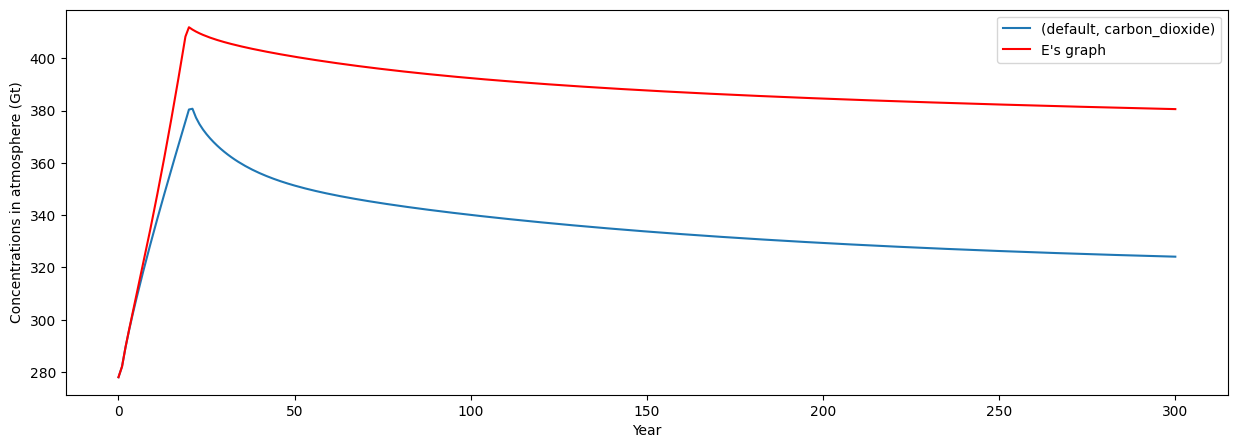

In [67]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
    
pulse_run_n['C']['carbon_dioxidepulse'].plot(ax=ax, legend=False)    
ax.plot(time_array,pulse_run_e['C_e'],'r', label="E's graph")  

plt.ylabel("Concentrations in atmosphere (Gt)")
ax.legend()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
    
pulse_run_n['T']['carbon_dioxidepulse'].plot(ax=ax,legend=False)    

pulse_run_e['T_e'].plot(ax=ax,legend=False)  

ax.legend()
plt.ylabel("Temperature increase (K)")

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
    
pulse_run_e['alpha_e'].plot(ax=ax,legend=False)
pulse_run_n['alpha']['carbon_dioxidepulse'].plot(ax=ax, legend=False)
    
ax.legend()
plt.ylabel("alpha factor")

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
    
pulse_run_e['RF_e'].plot(ax=ax,legend=False)
pulse_run_n['RF']['carbon_dioxidepulse'].plot(ax=ax, legend=False)
    
ax.legend()
plt.ylabel("Radiative Forcing in W/m^2")

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
    
pulse_run_e['Emissions_e'].plot(ax=ax,legend=False)
pulse_run_n['Emissions']['carbon_dioxidepulse'].plot(ax=ax, legend=False)
    
ax.legend()
plt.ylabel("Emissions injected (Gt)")